In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# chargement des données

In [28]:

try:
    data = pd.read_excel("../app/data/raw.xlsx")
except FileNotFoundError:
    print("Erreur: fichier 'online_retail.xlsx' introuvable")
except Exception as e:
    print(f"Erreur lors du chargement: {e}")


In [29]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [30]:
data.shape

(525461, 8)

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


# ÉTAPE 1 : AUDIT QUALITÉ ET NETTOYAGE PRÉLIMINAIRE

## 1.1 Dictionnaire des variables & Types

Vérifions d'abord la structure des données et les types de chaque colonne.

In [32]:
# Affichage des informations générales
print("=" * 70)
print("INFORMATIONS GÉNÉRALES DU DATASET")
print("=" * 70)
print(f"\nNombre de lignes : {data.shape[0]:,}")
print(f"Nombre de colonnes : {data.shape[1]}")
print(f"\nPériode couverte : {data['InvoiceDate'].min()} à {data['InvoiceDate'].max()}")

print("\n" + "=" * 70)
print("TYPES DE DONNÉES")
print("=" * 70)
print(data.dtypes)

print("\n" + "=" * 70)
print("APERÇU DES PREMIÈRES LIGNES")
print("=" * 70)
data.head(10)

INFORMATIONS GÉNÉRALES DU DATASET

Nombre de lignes : 525,461
Nombre de colonnes : 8

Période couverte : 2009-12-01 07:45:00 à 2010-12-09 20:01:00

TYPES DE DONNÉES
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

APERÇU DES PREMIÈRES LIGNES


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.0,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.0,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.0,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.0,United Kingdom


### 🔍 Analyse des types de données

**Observations attendues :**
- `InvoiceDate` devrait être en datetime64
- `Customer ID` est probablement en float64 (avec des .0) à cause des valeurs manquantes
- Les autres colonnes numériques (Quantity, Price) devraient être en int64/float64

**Actions requises :**
- Convertir `Customer ID` en format approprié après gestion des NaN
- Vérifier que `InvoiceDate` est bien en datetime

# 1.3 QUALITÉ DES DONNÉES
Avant de procéder au nettoyage, nous devons auditer le jeu de données pour identifier les problèmes potentiels qui pourraient biaiser l'analyse (RFM, CLV, Cohortes).

**Objectifs :**
1.  Quantifier les **données manquantes**, en particulier les identifiants clients.
2.  Détecter les **doublons** techniques.
3.  Comprendre les **règles de gestion** (annulations, prix négatifs).
4.  Vérifier la **couverture temporelle** (mois complets/incomplets).
5.  Repérer les **valeurs extrêmes** (outliers) influençant les moyennes.

### 1.3.1 Valeurs Manquantes
Le **Customer ID** est la clé de voûte de notre analyse client. Sans lui, impossible de lier des transactions entre elles pour calculer la fréquence ou la valeur vie.
Nous allons quantifier le volume de transactions orphelines pour décider de leur suppression.

In [33]:
# Analyse des valeurs manquantes
print("=" * 70)
print("VALEURS MANQUANTES PAR COLONNE")
print("=" * 70)

missing_data = pd.DataFrame({
    'Colonnes': data.columns,
    'Nombre_NaN': data.isnull().sum(),
    'Pourcentage': (data.isnull().sum() / len(data) * 100).round(2)
})

missing_data = missing_data[missing_data['Nombre_NaN'] > 0].sort_values(
    'Pourcentage', ascending=False
)

if len(missing_data) > 0:
    print(missing_data.to_string(index=False))
else:
    print("✅ Aucune valeur manquante détectée !")

print("\n" + "=" * 70)
print("DÉTAIL CUSTOMER ID")
print("=" * 70)
print(f"Transactions SANS Customer ID : {data['Customer ID'].isnull().sum():,} ({(data['Customer ID'].isnull().sum() / len(data) * 100):.2f}%)")
print(f"Transactions AVEC Customer ID : {data['Customer ID'].notna().sum():,} ({(data['Customer ID'].notna().sum() / len(data) * 100):.2f}%)")

VALEURS MANQUANTES PAR COLONNE
   Colonnes  Nombre_NaN  Pourcentage
Customer ID      107927        20.54
Description        2928         0.56

DÉTAIL CUSTOMER ID
Transactions SANS Customer ID : 107,927 (20.54%)
Transactions AVEC Customer ID : 417,534 (79.46%)


### 📊 Stratégie pour les valeurs manquantes

**Customer ID manquant :**
- **Problème critique** : Pour calculer CLV, RFM et les cohortes, nous avons **absolument besoin** du Customer ID
- Les transactions sans ID ne peuvent pas être attribuées à un client → impossible de mesurer la récurrence, la fréquence ou la valeur vie
- **Décision** : Supprimer les lignes sans Customer ID (nécessaire pour l'analyse client)

**Description manquante (si applicable) :**
- Moins critique pour CLV/RFM mais peut affecter l'analyse produit
- À traiter selon le pourcentage

### 1.3.2 Doublons
Des lignes strictement identiques (même facture, produit, date, client) indiquent souvent une **erreur technique** lors de l'extraction ou de l'enregistrement des données. Elles doivent être identifiées pour éviter de gonfler artificiellement le chiffre d'affaires.

In [34]:
# Détection des doublons
print("=" * 70)
print("ANALYSE DES DOUBLONS")
print("=" * 70)

nb_doublons = data.duplicated().sum()
print(f"\nNombre de lignes dupliquées (complètement identiques) : {nb_doublons:,}")
print(f"Pourcentage : {(nb_doublons / len(data) * 100):.2f}%")

if nb_doublons > 0:
    print("\n📋 Exemple de doublons :")
    print(data[data.duplicated(keep=False)].sort_values(
        ['Invoice', 'StockCode']
    ).head(6))

ANALYSE DES DOUBLONS

Nombre de lignes dupliquées (complètement identiques) : 6,865
Pourcentage : 1.31%

📋 Exemple de doublons :
    Invoice StockCode                       Description  Quantity  \
379  489517     21491   SET OF THREE VINTAGE GIFT WRAPS         1   
391  489517     21491   SET OF THREE VINTAGE GIFT WRAPS         1   
365  489517     21821  GLITTER STAR GARLAND WITH BELLS          1   
386  489517     21821  GLITTER STAR GARLAND WITH BELLS          1   
363  489517     21912          VINTAGE SNAKES & LADDERS         1   
371  489517     21912          VINTAGE SNAKES & LADDERS         1   

            InvoiceDate  Price  Customer ID         Country  
379 2009-12-01 11:34:00   1.95      16329.0  United Kingdom  
391 2009-12-01 11:34:00   1.95      16329.0  United Kingdom  
365 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
386 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
363 2009-12-01 11:34:00   3.75      16329.0  United Kingdom  
371 2009-12-01 

### 1.3.3 Annulations et Cohérence des Données
Dans ce dataset, les factures commençant par **'C'** désignent des annulations.
Par ailleurs, des **quantités négatives** (retours) ou des **prix nuls** (cadeaux, erreurs) peuvent exister. Il est crucial de les séparer des ventes réelles pour ne pas fausser le calcul du Panier Moyen ou de la CLV.

In [35]:
# Création d'un flag pour les annulations
data['IsCancel'] = data['Invoice'].astype(str).str.startswith('C')

print("=" * 70)
print("ANALYSE DES ANNULATIONS (Invoice commençant par 'C')")
print("=" * 70)

nb_annulations = data['IsCancel'].sum()
print(f"\nNombre d'annulations : {nb_annulations:,}")
print(f"Pourcentage : {(nb_annulations / len(data) * 100):.2f}%")
print(f"Nombre de transactions normales : {(~data['IsCancel']).sum():,}")

print("\n" + "=" * 70)
print("ANALYSE DES QUANTITÉS")
print("=" * 70)

print(f"\nQuantités négatives : {(data['Quantity'] < 0).sum():,}")
print(f"Quantités nulles : {(data['Quantity'] == 0).sum():,}")
print(f"Quantités positives : {(data['Quantity'] > 0).sum():,}")

print("\n" + "=" * 70)
print("ANALYSE DES PRIX")
print("=" * 70)

print(f"\nPrix négatifs : {(data['Price'] < 0).sum():,}")
print(f"Prix nuls : {(data['Price'] == 0).sum():,}")
print(f"Pourcentage prix nuls : {(data['Price'] == 0).sum() / len(data) * 100:.2f}%")

print("\n📋 Exemples de transactions avec prix = 0 :")
print(data[data['Price'] == 0][['Invoice', 'StockCode', 'Description', 'Quantity', 'Price']].head())

ANALYSE DES ANNULATIONS (Invoice commençant par 'C')

Nombre d'annulations : 10,206
Pourcentage : 1.94%
Nombre de transactions normales : 515,255

ANALYSE DES QUANTITÉS

Quantités négatives : 12,326
Quantités nulles : 0
Quantités positives : 513,135

ANALYSE DES PRIX

Prix négatifs : 3
Prix nuls : 3,687
Pourcentage prix nuls : 0.70%

📋 Exemples de transactions avec prix = 0 :
     Invoice StockCode   Description  Quantity  Price
263   489464     21733  85123a mixed       -96    0.0
283   489463     71477         short      -240    0.0
284   489467    85123A   21733 mixed      -192    0.0
470   489521     21646           NaN       -50    0.0
3114  489655     20683           NaN       -44    0.0


### ⚠️ Interprétation des annulations

**Observations :**
- Les factures avec 'C' sont des annulations (retours)
- Certaines quantités négatives peuvent exister même sans 'C' (corrections manuelles)
- Les prix à 0 peuvent être des échantillons gratuits, erreurs de saisie, ou promotions

**Stratégie pour CLV/RFM :**
1. **Option A (recommandée)** : Exclure complètement les annulations et prix/quantités invalides pour avoir une CLV "propre"
2. **Option B** : Garder les annulations pour calculer la CLV nette (revenus - retours)

Pour cette analyse exploratoire, nous allons séparer les données en :
- `data_clean` : transactions valides uniquement (pour RFM/CLV)
- `data_cancels` : annulations (pour analyse séparée si besoin)

### 1.3.4 Granularité Temporelle
Pour une analyse de cohortes fiable, il est préférable de travailler sur des **mois complets**. Si le dernier mois du dataset ne contient que quelques jours de données, il risque de montrer une fausse baisse de performance.

In [36]:
# Analyse de la granularité temporelle
print("=" * 70)
print("AUDIT : GRANULARITÉ TEMPORELLE")
print("=" * 70)

# Conversion en datetime si ce n'est pas déjà fait
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

min_date = data['InvoiceDate'].min()
max_date = data['InvoiceDate'].max()
duration = max_date - min_date

print(f"Date de début : {min_date}")
print(f"Date de fin   : {max_date}")
print(f"Couverture    : {duration.days} jours")
print(f"Années concernées : {data['InvoiceDate'].dt.year.unique()}")

# Vérification du dernier mois
last_month_count = data[data['InvoiceDate'].dt.to_period('M') == data['InvoiceDate'].max().to_period('M')].shape[0]
print(f"\n⚠️ Attention : Le dernier mois ({max_date.strftime('%Y-%m')}) s'arrête le {max_date.day}.")
print(">>> CONCLUSION : Le dernier mois est incomplet, il faudra probablement l'exclure des analyses de tendances.")

AUDIT : GRANULARITÉ TEMPORELLE
Date de début : 2009-12-01 07:45:00
Date de fin   : 2010-12-09 20:01:00
Couverture    : 373 jours
Années concernées : [2009 2010]

⚠️ Attention : Le dernier mois (2010-12) s'arrête le 9.
>>> CONCLUSION : Le dernier mois est incomplet, il faudra probablement l'exclure des analyses de tendances.


## 1.3.5 Détection des Outliers

Analyse statistique descriptive et visualisation des valeurs extrêmes pour Quantity et Price.

In [37]:
# Statistiques descriptives
print("=" * 70)
print("STATISTIQUES DESCRIPTIVES - QUANTITY & PRICE")
print("=" * 70)

print("\n📊 QUANTITY :")
print(data['Quantity'].describe())

print("\n📊 PRICE :")
print(data['Price'].describe())

# Calcul du montant total par transaction
data['TotalAmount'] = data['Quantity'] * data['Price']

print("\n📊 TOTAL AMOUNT (Quantity × Price) :")
print(data['TotalAmount'].describe())

STATISTIQUES DESCRIPTIVES - QUANTITY & PRICE

📊 QUANTITY :
count    525461.000000
mean         10.337667
std         107.424110
min       -9600.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: Quantity, dtype: float64

📊 PRICE :
count    525461.000000
mean          4.688834
std         146.126914
min      -53594.360000
25%           1.250000
50%           2.100000
75%           4.210000
max       25111.090000
Name: Price, dtype: float64

📊 TOTAL AMOUNT (Quantity × Price) :
count    525461.000000
mean         18.154506
std         160.333083
min      -53594.360000
25%           3.750000
50%           9.950000
75%          17.700000
max       25111.090000
Name: TotalAmount, dtype: float64


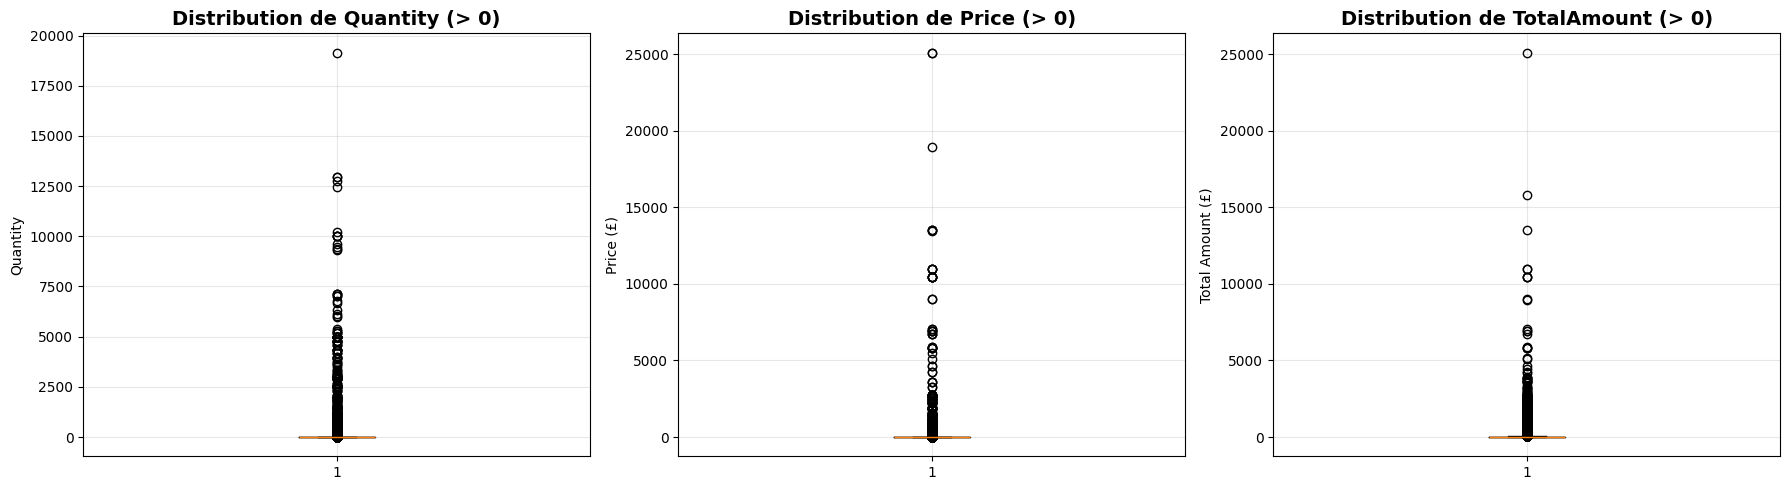


⚠️ VALEURS EXTRÊMES DÉTECTÉES :
Quantity max : 19,152
Price max : 25,111.09 £
TotalAmount max : 25,111.09 £
TotalAmount min : -53,594.36 £


In [38]:
# Visualisation des outliers avec boxplots
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Boxplot Quantity (seulement valeurs positives pour mieux voir)
data_positive = data[data['Quantity'] > 0]
axes[0].boxplot(data_positive['Quantity'])
axes[0].set_title('Distribution de Quantity (> 0)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Quantity')
axes[0].grid(True, alpha=0.3)

# Boxplot Price (seulement valeurs positives)
data_positive_price = data[data['Price'] > 0]
axes[1].boxplot(data_positive_price['Price'])
axes[1].set_title('Distribution de Price (> 0)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price (£)')
axes[1].grid(True, alpha=0.3)

# Boxplot TotalAmount (seulement valeurs positives)
data_positive_amount = data[data['TotalAmount'] > 0]
axes[2].boxplot(data_positive_amount['TotalAmount'])
axes[2].set_title('Distribution de TotalAmount (> 0)', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Total Amount (£)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️ VALEURS EXTRÊMES DÉTECTÉES :")
print(f"Quantity max : {data['Quantity'].max():,}")
print(f"Price max : {data['Price'].max():,.2f} £")
print(f"TotalAmount max : {data['TotalAmount'].max():,.2f} £")
print(f"TotalAmount min : {data['TotalAmount'].min():,.2f} £")

### 📈 Interprétation des outliers

**Ce que nous cherchons :**
- **Quantity** : Commandes anormalement grandes (> 10 000 unités = probablement grossiste/B2B)
- **Price** : Prix très élevés (> £1000 = produits premium ou erreurs)
- **TotalAmount** : Transactions très importantes (> £10 000 = clients VIP ou B2B)

**Impact sur CLV/RFM :**
- Les outliers peuvent fausser les moyennes → envisager des transformations (log) ou segmentation B2C vs B2B
- Pour le RFM, les montants extrêmes vont automatiquement créer des segments "Champions"
- À décider : conserver ou plafonner ces valeurs selon le contexte métier

## 📋 SYNTHÈSE DE L'ÉTAPE 1

Récapitulatif des actions à effectuer pour le nettoyage avant analyse RFM/CLV.

In [39]:
# Synthèse des problèmes détectés
print("=" * 70)
print("RÉSUMÉ DE L'AUDIT QUALITÉ")
print("=" * 70)

print(f"\n✅ Dataset initial : {len(data):,} lignes")
print(f"\n📊 PROBLÈMES IDENTIFIÉS :")
print(f"   • Customer ID manquants : {data['Customer ID'].isnull().sum():,} ({(data['Customer ID'].isnull().sum()/len(data)*100):.1f}%)")
print(f"   • Description manquante : {data['Description'].isnull().sum():,} ({(data['Description'].isnull().sum()/len(data)*100):.1f}%)")
print(f"   • Doublons complets : {data.duplicated().sum():,}")
print(f"   • Annulations (Invoice 'C') : {data['IsCancel'].sum():,}")
print(f"   • Quantités négatives : {(data['Quantity'] < 0).sum():,}")
print(f"   • Prix nuls : {(data['Price'] == 0).sum():,}")
print(f"   • Prix négatifs : {(data['Price'] < 0).sum():,}")

print(f"\n🎯 ACTIONS RECOMMANDÉES :")
print(f"   1️⃣ Supprimer les lignes sans Customer ID (nécessaire pour CLV/RFM)")
print(f"   2️⃣ Supprimer les doublons complets")
print(f"   3️⃣ Séparer les annulations des transactions normales")
print(f"   4️⃣ Exclure les transactions avec Price ≤ 0 ou Quantity ≤ 0")
print(f"   5️⃣ Convertir Customer ID en format string propre")
print(f"   6️⃣ Analyser les outliers (décision métier sur seuils)")

print("\n⏭️  Prêt à passer à l'étape de nettoyage effectif !")

RÉSUMÉ DE L'AUDIT QUALITÉ

✅ Dataset initial : 525,461 lignes

📊 PROBLÈMES IDENTIFIÉS :
   • Customer ID manquants : 107,927 (20.5%)
   • Description manquante : 2,928 (0.6%)
   • Doublons complets : 6,865
   • Annulations (Invoice 'C') : 10,206
   • Quantités négatives : 12,326
   • Prix nuls : 3,687
   • Prix négatifs : 3

🎯 ACTIONS RECOMMANDÉES :
   1️⃣ Supprimer les lignes sans Customer ID (nécessaire pour CLV/RFM)
   2️⃣ Supprimer les doublons complets
   3️⃣ Séparer les annulations des transactions normales
   4️⃣ Exclure les transactions avec Price ≤ 0 ou Quantity ≤ 0
   5️⃣ Convertir Customer ID en format string propre
   6️⃣ Analyser les outliers (décision métier sur seuils)

⏭️  Prêt à passer à l'étape de nettoyage effectif !


---

# ÉTAPE 2 : NETTOYAGE EFFECTIF DES DONNÉES

Application des 6 actions de nettoyage identifiées pour créer un dataset propre exploitable pour les analyses RFM/CLV/Cohortes.

## 2.1 Sauvegarde du dataset original

Créons une copie pour pouvoir revenir en arrière si nécessaire.

In [40]:
# Sauvegarde du dataset original
data_original = data.copy()
print(f"✅ Dataset original sauvegardé : {len(data_original):,} lignes")

✅ Dataset original sauvegardé : 525,461 lignes


## 2.2 Action 1 : Suppression des lignes sans Customer ID

**Justification** : Le Customer ID est indispensable pour :
- Calculer le RFM (Récence, Fréquence, Montant par client)
- Estimer la CLV (Customer Lifetime Value)
- Analyser les cohortes client

Sans ID, impossible d'attribuer une transaction à un client → données inutilisables pour notre objectif.

In [41]:
# Suppression des lignes sans Customer ID
print("=" * 70)
print("ACTION 1 : SUPPRESSION DES LIGNES SANS CUSTOMER ID")
print("=" * 70)

before = len(data)
data = data[data['Customer ID'].notna()].copy()
after = len(data)

print(f"\n✅ Lignes supprimées : {before - after:,} ({((before - after) / before * 100):.2f}%)")
print(f"✅ Lignes conservées : {after:,} ({(after / before * 100):.2f}%)")

ACTION 1 : SUPPRESSION DES LIGNES SANS CUSTOMER ID

✅ Lignes supprimées : 107,927 (20.54%)
✅ Lignes conservées : 417,534 (79.46%)


## 2.3 Action 2 : Suppression des doublons complets

Élimination des transactions identiques (même Invoice, StockCode, Quantity, Date, Client, etc.).

In [42]:
# Suppression des doublons
print("=" * 70)
print("ACTION 2 : SUPPRESSION DES DOUBLONS COMPLETS")
print("=" * 70)

before = len(data)
data = data.drop_duplicates().copy()
after = len(data)

print(f"\n✅ Doublons supprimés : {before - after:,}")
print(f"✅ Lignes conservées : {after:,}")

ACTION 2 : SUPPRESSION DES DOUBLONS COMPLETS



✅ Doublons supprimés : 6,771
✅ Lignes conservées : 410,763


## 2.4 Action 3 : Séparation des annulations

Création de deux datasets :
- **data_clean** : transactions normales uniquement (pour analyse RFM/CLV)
- **data_cancels** : annulations (pour analyse séparée si besoin)

**Note** : On exclut les annulations car elles fausseraient le calcul de CLV "brute". Une analyse avancée pourrait les réintégrer pour calculer une CLV nette.

In [43]:
# Séparation annulations vs transactions normales
print("=" * 70)
print("ACTION 3 : SÉPARATION DES ANNULATIONS")
print("=" * 70)

# Dataset des annulations (pour analyse séparée)
data_cancels = data[data['IsCancel']].copy()

# Dataset principal sans annulations
data_clean = data[~data['IsCancel']].copy()

print(f"\n✅ Transactions normales (data_clean) : {len(data_clean):,}")
print(f"✅ Annulations (data_cancels) : {len(data_cancels):,}")
print(f"\nPourcentage d'annulations : {(len(data_cancels) / len(data) * 100):.2f}%")

ACTION 3 : SÉPARATION DES ANNULATIONS

✅ Transactions normales (data_clean) : 400,947
✅ Annulations (data_cancels) : 9,816

Pourcentage d'annulations : 2.39%


## 2.5 Action 4 : Exclusion des transactions invalides

Suppression des lignes avec :
- **Quantity ≤ 0** (quantités négatives ou nulles)
- **Price ≤ 0** (prix négatifs ou nuls)

**Justification** : Ces valeurs invalides fausseraient les calculs de revenus et CLV.

In [44]:
# Exclusion des transactions avec Quantity ou Price invalides
print("=" * 70)
print("ACTION 4 : EXCLUSION DES TRANSACTIONS INVALIDES")
print("=" * 70)

before = len(data_clean)

# Analyse avant suppression
qty_invalid = (data_clean['Quantity'] <= 0).sum()
price_invalid = (data_clean['Price'] <= 0).sum()

print(f"\n📊 Transactions invalides détectées :")
print(f"   • Quantity ≤ 0 : {qty_invalid:,}")
print(f"   • Price ≤ 0 : {price_invalid:,}")

# Filtrage
data_clean = data_clean[(data_clean['Quantity'] > 0) & (data_clean['Price'] > 0)].copy()
after = len(data_clean)

print(f"\n✅ Lignes supprimées : {before - after:,}")
print(f"✅ Lignes conservées : {after:,} ({(after / before * 100):.2f}%)")

ACTION 4 : EXCLUSION DES TRANSACTIONS INVALIDES

📊 Transactions invalides détectées :
   • Quantity ≤ 0 : 0
   • Price ≤ 0 : 31



✅ Lignes supprimées : 31
✅ Lignes conservées : 400,916 (99.99%)


## 2.6 Action 5 : Conversion du Customer ID en format propre

Conversion de `Customer ID` :
- De float64 (avec .0) → int → string
- Cela facilite les manipulations et rend les IDs plus lisibles

In [45]:
# Conversion Customer ID en string propre
print("=" * 70)
print("ACTION 5 : CONVERSION CUSTOMER ID EN FORMAT PROPRE")
print("=" * 70)

print(f"\n📊 Type avant : {data_clean['Customer ID'].dtype}")
print(f"Exemple avant : {data_clean['Customer ID'].iloc[0]}")

# Conversion float → int → string
data_clean['Customer ID'] = data_clean['Customer ID'].astype(int).astype(str)

print(f"\n✅ Type après : {data_clean['Customer ID'].dtype}")
print(f"✅ Exemple après : {data_clean['Customer ID'].iloc[0]}")
print(f"\n✅ Nombre de clients uniques : {data_clean['Customer ID'].nunique():,}")

ACTION 5 : CONVERSION CUSTOMER ID EN FORMAT PROPRE

📊 Type avant : float64
Exemple avant : 13085.0

✅ Type après : object
✅ Exemple après : 13085

✅ Nombre de clients uniques : 4,312


## 2.7 Action 6 : Recalcul du TotalAmount et reset de l'index

Nettoyage final :
- Recalcul de `TotalAmount` sur les données propres
- Reset de l'index pour éviter des problèmes ultérieurs
- Suppression de la colonne temporaire `IsCancel`

In [46]:
# Nettoyage final
print("=" * 70)
print("ACTION 6 : NETTOYAGE FINAL")
print("=" * 70)

# Recalcul TotalAmount (au cas où il y aurait eu des modifications)
data_clean['TotalAmount'] = data_clean['Quantity'] * data_clean['Price']

# Suppression de la colonne temporaire IsCancel
data_clean = data_clean.drop('IsCancel', axis=1)

# Reset de l'index
data_clean = data_clean.reset_index(drop=True)

print(f"\n✅ Colonne TotalAmount recalculée")
print(f"✅ Colonne IsCancel supprimée")
print(f"✅ Index réinitialisé")
print(f"\n📊 Colonnes finales : {list(data_clean.columns)}")

ACTION 6 : NETTOYAGE FINAL

✅ Colonne TotalAmount recalculée
✅ Colonne IsCancel supprimée
✅ Index réinitialisé

📊 Colonnes finales : ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'TotalAmount']


## 📊 SYNTHÈSE COMPLÈTE DU NETTOYAGE

Bilan du pipeline de nettoyage et statistiques du dataset final.

In [47]:
# Synthèse complète du nettoyage
print("=" * 70)
print("🎯 SYNTHÈSE COMPLÈTE DU NETTOYAGE")
print("=" * 70)

print(f"\n📊 ÉVOLUTION DES DONNÉES :")
print(f"   • Dataset original : {len(data_original):,} lignes")
print(f"   • Dataset nettoyé (data_clean) : {len(data_clean):,} lignes")
print(f"   • Lignes supprimées : {len(data_original) - len(data_clean):,} ({((len(data_original) - len(data_clean)) / len(data_original) * 100):.2f}%)")
print(f"   • Taux de rétention : {(len(data_clean) / len(data_original) * 100):.2f}%")

print(f"\n👥 CLIENTS :")
print(f"   • Nombre de clients uniques : {data_clean['Customer ID'].nunique():,}")
print(f"   • Nombre moyen de transactions par client : {(len(data_clean) / data_clean['Customer ID'].nunique()):.2f}")

print(f"\n🌍 GÉOGRAPHIE :")
print(f"   • Nombre de pays : {data_clean['Country'].nunique()}")

print(f"\n📦 PRODUITS :")
print(f"   • Nombre de produits uniques : {data_clean['StockCode'].nunique():,}")

print(f"\n💰 STATISTIQUES FINANCIÈRES :")
print(f"   • Revenu total : £{data_clean['TotalAmount'].sum():,.2f}")
print(f"   • Panier moyen : £{data_clean['TotalAmount'].mean():.2f}")
print(f"   • Panier médian : £{data_clean['TotalAmount'].median():.2f}")

print(f"\n📅 PÉRIODE :")
print(f"   • Début : {data_clean['InvoiceDate'].min()}")
print(f"   • Fin : {data_clean['InvoiceDate'].max()}")
print(f"   • Durée : {(data_clean['InvoiceDate'].max() - data_clean['InvoiceDate'].min()).days} jours")

print(f"\n✅ Dataset 'data_clean' prêt pour les analyses RFM, CLV et Cohortes !")

🎯 SYNTHÈSE COMPLÈTE DU NETTOYAGE

📊 ÉVOLUTION DES DONNÉES :
   • Dataset original : 525,461 lignes
   • Dataset nettoyé (data_clean) : 400,916 lignes
   • Lignes supprimées : 124,545 (23.70%)
   • Taux de rétention : 76.30%

👥 CLIENTS :
   • Nombre de clients uniques : 4,312
   • Nombre moyen de transactions par client : 92.98

🌍 GÉOGRAPHIE :
   • Nombre de pays : 37

📦 PRODUITS :
   • Nombre de produits uniques : 4,017

💰 STATISTIQUES FINANCIÈRES :
   • Revenu total : £8,798,233.74
   • Panier moyen : £21.95
   • Panier médian : £12.50

📅 PÉRIODE :
   • Début : 2009-12-01 07:45:00
   • Fin : 2010-12-09 20:01:00
   • Durée : 373 jours

✅ Dataset 'data_clean' prêt pour les analyses RFM, CLV et Cohortes !


In [48]:
# Vérification finale : aucune valeur manquante ou invalide
print("\n" + "=" * 70)
print("🔍 VÉRIFICATION FINALE DE LA QUALITÉ")
print("=" * 70)

print(f"\n✅ Valeurs manquantes par colonne :")
missing_final = data_clean.isnull().sum()
if missing_final.sum() == 0:
    print("   → Aucune valeur manquante ! 🎉")
else:
    print(missing_final[missing_final > 0])

print(f"\n✅ Valeurs invalides :")
print(f"   • Quantity ≤ 0 : {(data_clean['Quantity'] <= 0).sum()} (attendu: 0)")
print(f"   • Price ≤ 0 : {(data_clean['Price'] <= 0).sum()} (attendu: 0)")
print(f"   • TotalAmount ≤ 0 : {(data_clean['TotalAmount'] <= 0).sum()} (attendu: 0)")

print(f"\n✅ Aperçu du dataset nettoyé :")
data_clean.head()


🔍 VÉRIFICATION FINALE DE LA QUALITÉ

✅ Valeurs manquantes par colonne :
   → Aucune valeur manquante ! 🎉

✅ Valeurs invalides :
   • Quantity ≤ 0 : 0 (attendu: 0)
   • Price ≤ 0 : 0 (attendu: 0)
   • TotalAmount ≤ 0 : 0 (attendu: 0)

✅ Aperçu du dataset nettoyé :


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [49]:
data_clean.to_csv('../app/data/processed.csv', index=False)


# ÉTAPE 4: Graphiques visuels


## 4.1 Graohique 1 : Distributions


In [66]:
# Quantité moyenne par facture
qty_per_invoice = data_clean.groupby('Invoice')['Quantity'].mean().reset_index()

qty_per_invoice['ClientType'] = qty_per_invoice['Quantity'].apply(
    lambda x: 'Grossiste' if x > 50 else 'Détaillant'
)

df = data_clean.merge(qty_per_invoice[['Invoice', 'ClientType']], on='Invoice', how='left')

# Comptage
counts = qty_per_invoice['ClientType'].value_counts()

fig = go.Figure(
    data=[go.Pie(
        labels=counts.index,
        values=counts.values,
        hole=0.3
    )]
)

fig.update_layout(
    title="Répartition Grossistes / Détaillants"
)

fig.show()

In [67]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Mois d'achat
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()

# Mois de première commande
first_purchase = df.groupby('Customer ID')['InvoiceMonth'].min()

df['CohortMonth'] = df['Customer ID'].map(first_purchase)

# Âge de cohorte (mois)
df['CohortIndex'] = (
    (df['InvoiceMonth'].dt.year - df['CohortMonth'].dt.year) * 12 +
    (df['InvoiceMonth'].dt.month - df['CohortMonth'].dt.month) + 1
)

# Table cohortes
cohort = df.groupby(['CohortMonth', 'CohortIndex'])['Customer ID'].nunique().reset_index()

# Pivot
cohort_pivot = cohort.pivot(index='CohortMonth', columns='CohortIndex', values='Customer ID')

fig = go.Figure(
    data=go.Heatmap(
        z=cohort_pivot.values,
        x=cohort_pivot.columns,
        y=cohort_pivot.index.astype(str),
        colorscale='Blues'
    )
)

fig.update_layout(
    title="Analyse des Cohortes (Clients uniques)",
    xaxis_title="Mois depuis première commande",
    yaxis_title="Cohorte"
)

fig.show()

In [68]:
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                      # Frequency
    'TotalAmount': 'sum'                                       # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=rfm['Recency'],
        y=rfm['Monetary'],
        mode='markers',
        marker=dict(
            size=8,
            color=rfm['Frequency'],
            colorscale='Viridis',
            colorbar=dict(title="Frequency")
        ),
        text=rfm['CustomerID']
    )
)

fig.update_layout(
    title="Profil RFM – Vue Initiale",
    xaxis_title="Récence (jours)",
    yaxis_title="Montant total (€)"
)

fig.show()

In [65]:
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display

# --- Mapping variable : NOM AFFICHÉ → NOM DANS DATASET ---
variables = {
    "Montant total (€)": "TotalAmount",
    "Prix unitaire (€)": "Price",
    "Quantité": "Quantity"
}

# Graphiques disponibles
chart_types = {
    "Histogramme": "hist",
    "Violin plot": "violin"
}

# 🎛️ Widgets interactifs

var_select = widgets.Dropdown(
    options=list(variables.keys()),
    description="Variable :",
    style={'description_width': '150px'},
    layout=widgets.Layout(width="450px")
)

chart_select = widgets.Dropdown(
    options=list(chart_types.keys()),
    description="Graphique :",
    style={'description_width': '150px'},
    layout=widgets.Layout(width="450px")
)

percentile_slider = widgets.IntSlider(
    value=95,
    min=80,
    max=100,
    step=1,
    description="Filtre percentile :",
    continuous_update=False,
    style={'description_width': '150px'}
)

# 📊 Fonction d’affichage 

def afficher_graphique(var_label, chart_label, perc):

    col = variables[var_label]

    # --- Filtre percentile (zoom intelligent) ---
    pmax = data_clean[col].quantile(perc / 100)
    subset = data_clean[data_clean[col] <= pmax]

    # statistiques
    mean_val = subset[col].mean()
    median_val = subset[col].median()

    # --- Titre principal + sous-titre ---
    title = f"Distribution de {var_label}"
    subtitle = f"Filtré ≤ P{perc} ({round(pmax, 2)}) — Nombre de transactions dans cet intervalle"

    # 📘 Création du graphique
  
    if chart_types[chart_label] == "hist":
        fig = px.histogram(
            subset,
            x=col,
            nbins=40,
            opacity=0.75,
            title=title
        )

        # Ajouter lignes moyenne + médiane
        fig.add_vline(x=mean_val, line_width=2, line_dash="dash", line_color="blue",
                      annotation_text=f"Moyenne : {mean_val:.2f}", annotation_position="top left")

        fig.add_vline(x=median_val, line_width=2, line_dash="dot", line_color="red",
                      annotation_text=f"Médiane : {median_val:.2f}", annotation_position="bottom left")

        fig.update_yaxes(title="Nombre de transactions dans cet intervalle")

    elif chart_types[chart_label] == "violin":
        # Version du violin plot qui marchait
        fig = px.violin(
            subset,
            y=col,
            box=True,          # boxplot inclus comme avant
            points=False,
            title=title
        )
        fig.update_yaxes(title=var_label)

    # 🎨 Style moderne

    fig.update_layout(
        template="simple_white",
        width=1000,
        height=550,
        title={
            "text": f"{title}<br><sup>{subtitle}</sup>",
            "y": 0.95,
            "x": 0.05,
            "xanchor": "left"
        },
        font=dict(size=14),
    )

    fig.update_xaxes(title=var_label)

    fig.show()


# 🚀 Interface interactive

display(
    widgets.interactive(
        afficher_graphique,
        var_label=var_select,
        chart_label=chart_select,
        perc=percentile_slider
    )
)


interactive(children=(Dropdown(description='Variable :', layout=Layout(width='450px'), options=('Montant total…

## 4.2 graphiques visuels 2: saisonnalités/ tendance


In [ ]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")


# Assurer que InvoiceDate est en datetime
data_clean["InvoiceDate"] = pd.to_datetime(data_clean["InvoiceDate"])

# Ajouter colonne transaction si absente
if "TransactionCount" not in data_clean.columns:
    data_clean["TransactionCount"] = 1

# Variables analysables
variables = {
    "Montant total (€)": "TotalAmount",
    "Nombre de transactions": "TransactionCount"
}

# Granularité : ajout de "Par saison"
granularites = {
    "Par jour": "day",
    "Par semaine": "week",
    "Par mois": "month",
    "Par saison": "season"
}

# Types de graphiques
chart_types = {
    "Courbe temporelle": "line",
    "Heatmap": "heatmap"
}

# Widgets
var_select = widgets.Dropdown(
    options=list(variables.keys()),
    description="Variable :",
    layout=widgets.Layout(width="350px")
)

gran_select = widgets.Dropdown(
    options=list(granularites.keys()),
    description="Périodicité :",
    layout=widgets.Layout(width="350px")
)

chart_select = widgets.Dropdown(
    options=list(chart_types.keys()),
    description="Graphique :",
    layout=widgets.Layout(width="350px")
)

# Sélecteur de mois (visible uniquement pour Par jour)
month_select = widgets.Dropdown(
    options={
        "Janvier": 1, "Février": 2, "Mars": 3, "Avril": 4,
        "Mai": 5, "Juin": 6, "Juillet": 7, "Août": 8,
        "Septembre": 9, "Octobre": 10, "Novembre": 11, "Décembre": 12
    },
    description="Mois :",
    layout=widgets.Layout(width="350px")
)

# Conteneur dynamique
month_box = widgets.VBox([month_select])
month_box.layout.display = "none"

def update_month_visibility(*args):
    if gran_select.value == "Par jour":
        month_box.layout.display = "block"
    else:
        month_box.layout.display = "none"

gran_select.observe(update_month_visibility, "value")

# ==============================================================
# 🔥 FONCTION PRINCIPALE
# ==============================================================

def afficher_saisonnalite(var_label, gran_label, chart_label, month):

    col = variables[var_label]
    df = data_clean.copy()

    # Ajout des composantes temporelles
    df["Month"] = df["InvoiceDate"].dt.month
    df["Day"] = df["InvoiceDate"].dt.day
    df["Week"] = df["InvoiceDate"].dt.isocalendar().week

    # ---------------------------
    # 🔥 Définition correcte des saisons
    # ---------------------------
    df["Saison"] = pd.cut(
        df["Month"],
        bins=[0, 3, 6, 9, 12],      # 4 intervalles → 4 labels
        labels=["Hiver", "Printemps", "Été", "Automne"],
        right=False
    )

    # -------------------------------
    # 1️⃣ JOUR DANS UN MOIS
    # -------------------------------
    if granularites[gran_label] == "day":

        df_sel = df[df["Month"] == month]
        df_day = df_sel.groupby("Day")[col].sum().reset_index()

        if chart_label == "Courbe temporelle":
            fig = px.line(df_day, x="Day", y=col, markers=True,
                          title=f"Tendance journalière — {var_label}")
        else:
            fig = px.imshow(
                [df_day[col].values],
                labels=dict(x="Jour", color=var_label),
                title="Heatmap journalière"
            )

        fig.update_layout(template="simple_white", width=1000, height=500)
        fig.show()
        return

    # -------------------------------
    # 2️⃣ PAR SEMAINE
    # -------------------------------
    if granularites[gran_label] == "week":

        df_week = df.groupby("Week")[col].sum().reset_index()

        if chart_label == "Courbe temporelle":
            fig = px.line(df_week, x="Week", y=col, markers=True,
                          title=f"Tendance hebdomadaire — {var_label}")
        else:
            fig = px.imshow(
                [df_week[col].values],
                labels=dict(x="Semaine", color=var_label),
                title="Heatmap hebdomadaire"
            )

        fig.update_layout(template="simple_white", width=1000, height=500)
        fig.show()
        return

    # -------------------------------
    # 3️⃣ PAR MOIS
    # -------------------------------
    if granularites[gran_label] == "month":

        df_month = df.groupby("Month")[col].sum().reset_index()

        if chart_label == "Courbe temporelle":
            fig = px.line(df_month, x="Month", y=col, markers=True,
                          title=f"Tendance mensuelle — {var_label}")
        else:
            fig = px.imshow(
                [df_month[col].values],
                labels=dict(x="Mois", color=var_label),
                title="Heatmap mensuelle"
            )

        fig.update_layout(template="simple_white", width=1000, height=500)
        fig.show()
        return

    # -------------------------------
    # 4️⃣ PAR SAISON
    # -------------------------------
    if granularites[gran_label] == "season":

        df_season = df.groupby("Saison")[col].sum().reset_index()

        if chart_label == "Courbe temporelle":
            fig = px.line(df_season, x="Saison", y=col, markers=True,
                          title=f"Tendance saisonnière — {var_label}")
        else:
            fig = px.imshow(
                [df_season[col].values],
                labels=dict(x="Saison", color=var_label),
                title="Heatmap saisonnière"
            )

        fig.update_layout(template="simple_white", width=1000, height=500)
        fig.show()
        return


# ==============================================================
# Interface finale
# ==============================================================

ui = widgets.VBox([
    var_select,
    gran_select,
    month_box,
    chart_select
])

display(
    ui,
    widgets.interactive_output(
        afficher_saisonnalite,
        {
            "var_label": var_select,
            "gran_label": gran_select,
            "chart_label": chart_select,
            "month": month_select
        }
    )
)

Output()

## 4.3 graphiques visuels 3: répartition pays


In [ ]:
# Normalisation des noms de pays
country_mapping = {
    "EIRE": "Ireland",
    "RSA": "South Africa",
    "Channel Islands": "United Kingdom",
    "West Indies": "Caribbean",
    "USA": "United States",
    "Korea": "South Korea",
    "Unspecified": None,
}

In [ ]:
df_geo = data_clean.copy()
df_geo["Country"] = df_geo["Country"].replace(country_mapping)
df_geo = df_geo.dropna(subset=["Country"])  # Retire "Unspecified"

In [61]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px

# 1. D'abord, on prépare les données pour la carte (Aggrégation)
# On part de votre dataframe actuel (data_clean) qui contient les colonnes brutes
df_map = data_clean.groupby("Country").agg({
    'Invoice': 'nunique',      # Compte le nombre de factures uniques
    'TotalAmount': 'sum',      # Somme des montants
    'Quantity': 'sum'          # Somme des quantités
}).reset_index()

# 2. On renomme les colonnes pour qu'elles correspondent à votre menu déroulant
df_map.columns = ['country', 'transactioncount', 'totalamount', 'quantity']

# --- CONFIGURATION DU WIDGET ---

column_map = {
    "Nombre de transactions": "transactioncount",
    "Montant total (€)": "totalamount",
    "Quantité totale": "quantity"
}

var_select = widgets.Dropdown(
    options=list(column_map.keys()),
    description="Variable :",
    style={'description_width': '150px'},
    layout=widgets.Layout(width="450px")
)

def afficher_carte(var_label):
    # Sécurité
    if var_label not in column_map:
        return

    col = column_map[var_label]
    
    # IMPORTANT : On utilise df_map (les données groupées) et non data_clean
    df = df_map.copy()

    # --- Gestion Echelle (UK vs Monde) ---
    if "United Kingdom" in df["country"].values:
        uk_val = df[df["country"] == "United Kingdom"][col].iloc[0]
        other = df[df["country"] != "United Kingdom"]
    else:
        uk_val = 0
        other = df

    vmin = other[col].min()
    vmax = other[col].max()

    # Colonne couleur
    df["ColorValue"] = df[col]
    if "United Kingdom" in df["country"].values:
        df.loc[df["country"] == "United Kingdom", "ColorValue"] = vmax

    # --- Affichage Carte ---
    fig = px.choropleth(
        df,
        locations="country",
        locationmode="country names",
        color="ColorValue",
        hover_name="country",
        # On affiche la vraie valeur (col) et on cache la valeur de couleur truquée
        hover_data={col: True, "ColorValue": False},
        color_continuous_scale="Viridis_r",
        range_color=(vmin, vmax),
        projection="natural earth",
        title=f"Répartition — {var_label}"
    )
    
    # Annotation UK
    if uk_val > 0:
        fig.add_annotation(
            x=1.00, y=0.25, xref="paper", yref="paper",
            showarrow=False, align="left",
            text=f"<b>Royaume-Uni :</b><br>{uk_val:,.0f}<br><span style='color:#440154;'><b>(Hors échelle)</b></span>",
        )

    fig.update_layout(height=600, margin=dict(l=0, r=0, t=50, b=0))
    fig.show()

# Lancement
display(widgets.interactive(afficher_carte, var_label=var_select))

interactive(children=(Dropdown(description='Variable :', layout=Layout(width='450px'), options=('Nombre de tra…